## Recap

**Bag of words**: No tiene en cuenta el orden de las palabras en una frase.

**RNNs**: Tiene en cuenta el contexto de la palabra, i.e. el orden de las mismas. Pero presenta los problemas de los gradientes explosivos (fáciles de solucionar truncando gradientes) y **desaparecidos** (el modelo deja de aprender o lo hace muy lentamente).

**LSTMs**: Guarda en memoria parte de la información sobre las palabras anteriores. La línea *memoria* contiene tres puertas, la puerta de olvida, de entrada y de salida, que la modifican. No obstante, las LSTMs presentan problemas:

- Son difíciles de entrenar.
- Son operaciones en serie (una palabra después de la otra, con lo cual hasta que no acabe la anterior no se procede, ralentizando el proceso).
- El aprendizaje por transferencia no funciona. No se puede utilizar lo que hemos aprendido con una base de datos para ser aplicado a un nuevo problema.

## Transformers

Existen dos partes en la arquitectura transformer, el **codificador** (*encoder*) y el **decodificador** (*decoder*). Tanto el codificador como el decodificador apilan una serie de codificadores/decodificadores. En cada uno de ellos tenemos una capa de atención, y una red neuronal *feed forward*. 

El objetivo de la capa de **atención** es que el codificador tenga en cuenta el resto de palabras de una frase cuando está codificando una palabra determinada. En la feed-forward no hay interacción entre las palabras, esto lo hace la capa de atención. De esta manera se pueden hacer todas las operaciones en paralelo, siendo más eficientes de cara a entrenar que  las LSTMs.

Codificadores: (lista de vectores) --> output --> word embeddings --> output.



## Ventajas de los transformers

- Las operaciones se pueden realizar en paralelo, siendo el coste de entrenamiento mucho menor.
- Mecanismo de activación ReLU (en lugar de sigmoid o tanh). Como es una función discontinua, rompe la linealidad de los valores de entrada y hace que se asemejen más a la vida real.
    - Valores más significativos. Es una función que cambia mucho más rápido que las otras.
    - Menos sensibles a inicialización aleatoria.
    - Gradiente no satura y es muy fácil de calcular; cero para números negativos y uno para positivos.
- Aprendizaje por transferencia. 

<img src="encoder_decoder.png">

Justo después de hacer el embedding y antes de entrar en el codificador y decodificador, tenemos el **positional encoding**, que se utiliza para saber el orden de las palabras en la frase. Como en transformers procesamos todas las palabras a la vez (no en serie como LSTMs), se podría perder el orden de la frase, pero esto no es así debido al positional encoding. Se suma un vector adicional a cada word embedding para cada palabra. Estos vectores se emplean para saber la posición de cada palabra en la frase. Para saber qué valores se suman, se utilizan funciones sinusoidales. Ejemplo: Oración con 5 palabras. A la primera palabra, le sumas 0, a la siguiente, le sumas 0.33, y así sucesivamente siguiendo un patrón sinusoidal. En función de lo que sumes, sabes cuál es la posición.

El mecanismo **multi-head attention**. Una función de atención mapea una *query* y unos pares *key-value* a un output. El output se calcula como una suma pesada de los *values*, donde el peso asignado a cada alor se calcula usando una función de compatibilidad que asocia la *query* con su respondiente *key*. Para cada output, consideramos todos los posibles inputs (*all-to-all comparison*).

- Output: Consulta (*query*).
- Input: Par llave-valor (*key-value*).

El mecanismo de atención es una **softmax** function, que tiene en cuenta el *query Q* y los *keys* para proporcionar vectores de pesos a aplicar sobre los *values*. Tanto las queries como los keys son de dimensión $d_{k}$, mientras que los valores son de dimensión $d_{v}$.

$Attention(Q,K,V) = \text{softmax}\left(\frac{QK^{T}}{\sqrt{d_{k}}}\right)V$

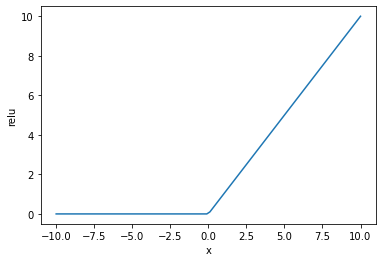

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def relu(x):
    return max(0.0, x)

x = np.linspace(-10,10,100)
y = list(map(relu,x))
plt.plot(x,y)
plt.ylabel('relu')
plt.xlabel('x')
plt.show()

In [2]:
##Import necessary packages
import torch
from torch import nn
from torch import Tensor
import math
from typing import Optional

In [3]:
class MultiHeadedAttention(nn.Module):
    '''
    BLoque de MultiHeadedAttention que permita al modelo atender de manera
    conjunta a información de diferentes subespacios de representación.

    Args:
        num_heads (int): número de cabezas por capa
        d_model (int): dimensión total del modelo
        dropout (float): Una capa de dropout sobre attention_probs. Default: 0.0. 
    '''
    def __init__(self, num_heads: int, d_model: int, dropout: float = 0.0):
        super(MultiHeadedAttention, self).__init__() #In python, the super() function returns an object that represents the parent class
        if d_model % num_heads != 0:
            raise ValueError(
                f"The hidden size ({d_model}) is not a multiple of the number of attention "
                f"heads ({num_heads})"
            )
        # Número de features por cabeza, se asume que d_v = d_k
        self.d_k = d_model // num_heads
        self.d_model = d_model
        self.num_heads = num_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        # A dropout layers reduces the number of neurons in a hidden layer so that the model also learns to work without these neurons 
        self.dropout = nn.Dropout(p=dropout)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.d_k)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        mask: Optional[Tensor] = None,
        output_attentions: Optional[bool] = False
    ):
        '''
        Args:
            query, key, value: Se mapea el query y un conjunto de parejas key-value a una salida output.
            mask: máscara que previene la atención en ciertas posiciones.
            output_attentions: Indica si se quiere regresar la matriz de pesos de atención
        '''
        if mask is not None:
            # Se aplica la misma máscara para todas las cabezas
            mask = mask.unsqueeze(1)
        
        query_layer = self.transpose_for_scores(self.query(query)) # (batch, num_heads, seq_len, d_k)
        key_layer = self.transpose_for_scores(self.key(key))
        value_layer = self.transpose_for_scores(self.value(value))

        # Se realiza el producto punto entre "query" y "key" para obtener los scores de atención crudos/sin procesar
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.d_k)

        # Se aplica máscara
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        # Se normalizan los scores de atención a probabilidades
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() # (batch, seq_len, num_heads, d_k)
        #permute changes the position of each element in torch object
        new_context_layer_shape = context_layer.size()[:-2] + (self.d_model,) # (batch, seq_len, d_model)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs

In [4]:
# Creamos una instance de la clase MultiHeadedAttention
att = MultiHeadedAttention(8,768,0.1) 

In [5]:
# Creamos una entrada con tamaño de lote de 8 y secuencias de 300 elementos aleatorios. 768 es la dimensión total del model
x = torch.rand(8,300,768) # This has the same structure as a numpy array
mask = torch.ones((8,300))

# Ejecutar módulo, se regresa la matriz de atención
output = att(query=x, key=x, value=x, mask=mask, output_attentions=True)

In [6]:
# Embedding de salida
print (output[0].shape)

torch.Size([8, 300, 768])


In [7]:
# Matriz de atención
print (output[1].shape)

torch.Size([8, 8, 300, 300])


In [8]:
from transformers import BertModel, BertTokenizer
from bertviz import head_view

In [9]:
# Descargamos dos modelos pre-entrenados

bert = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
bert_embeddings_layer = bert.embeddings
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

att = MultiHeadedAttention(8, 768, 0.1)

# Cargamos los parámetros de los modelos pre-entrenados para nuestra multi-headed attention. Estos se obtienen usando
# un state_dict deserializado. Esto se trata de un diccionario que mapea cada capa a su respectivo parámetro en el tensor

att.query.load_state_dict(bert.encoder.layer[0].attention.self.query.state_dict())
att.key.load_state_dict(bert.encoder.layer[0].attention.self.key.state_dict())
att.value.load_state_dict(bert.encoder.layer[0].attention.self.value.state_dict())

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

<All keys matched successfully>

In [10]:
#Cogemos los tokens
text_input = tokenizer(["El perro va caminando sobre el pasto"], return_tensors='pt') #return pytorch tensor
print (text_input)

{'input_ids': tensor([[    4,  1162,  5659,  1768, 13539,  1269,  1040,  1343,  1071,     5]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [11]:
input_ids = text_input['input_ids']
x = bert_embeddings_layer(input_ids) # return the embedded vector for each associated word
mask = text_input['attention_mask'] # the attention mask is a binary tensor indicating the position of the padded indeces
# so that the model does not attend to them. 1 indicates a value should be attended, 0 indicates padded value

output, attention_scores = att(query=x,key=x,value=x,mask=mask,output_attentions=True)

In [12]:
attention_scores.shape

torch.Size([1, 8, 10, 10])

In [13]:
input_id_list = input_ids.tolist()[0]
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
print (tokens)

['[CLS]', 'El', 'perro', 'va', 'caminando', 'sobre', 'el', 'pas', '##to', '[SEP]']


In [14]:
head_view((attention_scores,)*12, tokens)

<IPython.core.display.Javascript object>

In [15]:
import numpy as np
import string

In [16]:
class CounterModel(nn.Module):
    def __init__(self, num_heads: int = 1, d_model: int = 64, dropout: float = 0.1, emb_dim: int = 64, vocab_size: int = 3, max_len: int = 10):
        super(CounterModel, self).__init__()
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=emb_dim)
        self.query = nn.Linear(in_features=emb_dim, out_features=1).weight
        self.mh_att = MultiHeadedAttention(num_heads, d_model, dropout)
        self.classification_head = nn.Linear(in_features=emb_dim, out_features=max_len+1)
    
    def forward(self, letter_sequence):
        #print(letter_sequence.shape)
        batch_size = input_batch.shape[0]
        letter_sequence_ids = (input_batch == 1).nonzero(as_tuple=True)[-1].reshape((batch_size,-1))
        #cls_tokens = torch.ones((batch_size,1), dtype=torch.long)*(self.vocab_size+1)
        #letter_sequence_ids = torch.concat((cls_tokens, letter_sequence_ids), 1)
        x = self.embeddings(letter_sequence_ids)
        #print(x.shape)
        q_r = self.query.repeat((batch_size,self.vocab_size,1))
        output, attention_scores = self.mh_att(query=q_r, key=x, value=x, mask=None, output_attentions=True)
        #print(output.shape)
        logits = self.classification_head(output)
        #print(logits.shape)
        return logits
    
class Task(object):

	def __init__(self, max_len=10, vocab_size=3):
		super(Task, self).__init__()
		self.max_len = max_len
		self.vocab_size = vocab_size
		assert self.vocab_size <= 26, "vocab_size needs to be <= 26 since we are using letters to prettify LOL"

	def next_batch(self, batchsize=100):
		x = np.eye(self.vocab_size + 1)[np.random.choice(np.arange(self.vocab_size + 1), [batchsize, self.max_len])]
		y = np.eye(self.max_len + 1)[np.sum(x, axis=1)[:, 1:].astype(np.int32)]
		return x, y

	def prettify(self, samples):
		samples = samples.reshape(-1, self.max_len, self.vocab_size + 1)
		idx = np.expand_dims(np.argmax(samples, axis=2), axis=2)
		dictionary = np.array(list(' ' + string.ascii_uppercase))
		return dictionary[idx]

In [17]:
task = Task(max_len=10, vocab_size=3)
minibatch_x, minibatch_y = task.next_batch(batchsize=2)
print(minibatch_x)
print(minibatch_y)

[[[0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]]

 [[0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]]
[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]]


In [18]:
minibatch_y.shape

(2, 3, 11)

In [20]:
task.prettify(minibatch_x)

array([[['C'],
        ['A'],
        [' '],
        [' '],
        ['C'],
        ['B'],
        ['B'],
        ['B'],
        [' '],
        ['C']],

       [['A'],
        ['C'],
        [' '],
        ['A'],
        [' '],
        [' '],
        ['C'],
        ['A'],
        ['B'],
        ['B']]], dtype='<U1')

In [21]:
input_batch = torch.tensor(minibatch_x, dtype=torch.long)
input_batch_ids = (input_batch == 1).nonzero(as_tuple=True)[-1].reshape((input_batch.shape[0],-1))
cls_token = torch.ones((2,1), dtype=torch.long)*4
torch.concat((cls_token, input_batch_ids), 1)
model = CounterModel()
model(input_batch)
q = nn.Linear(in_features=10, out_features=1, bias=False).weight
q_r = q.repeat((2,3,1))
k = torch.rand((2,5,10))
v = torch.rand((2,5,10))
probs = torch.matmul(q_r, k.transpose(-1, -2))
context_layer = torch.matmul(probs, v)

In [22]:
model = CounterModel(num_heads=1, d_model=32, dropout=0.1, emb_dim=32)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
model.train()

CounterModel(
  (embeddings): Embedding(4, 32)
  (mh_att): MultiHeadedAttention(
    (query): Linear(in_features=32, out_features=32, bias=True)
    (key): Linear(in_features=32, out_features=32, bias=True)
    (value): Linear(in_features=32, out_features=32, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (classification_head): Linear(in_features=32, out_features=11, bias=True)
)

In [24]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

3691

In [25]:
dataset = [task.next_batch(batchsize=128) for i in range(100)]

In [26]:
for step in range(5000):
    # get the inputs; data is a list of [inputs, labels]
    i = step%100
    #input_batch, label_batch = task.next_batch(batchsize=128)
    input_batch, label_batch = dataset[i]
    input_batch = torch.tensor(input_batch, dtype=torch.long)
    label_batch = torch.tensor(label_batch, dtype=torch.float)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(input_batch)
    loss = criterion(outputs, label_batch)
    loss.backward()
    optimizer.step()

    # print statistics
    if step % 100 == 0:
        print(f'step: {step + 1} | loss: {loss.item():.3f}')

print('Finished Training')

step: 1 | loss: 0.300
step: 101 | loss: 0.300
step: 201 | loss: 0.300
step: 301 | loss: 0.300
step: 401 | loss: 0.300
step: 501 | loss: 0.299
step: 601 | loss: 0.300
step: 701 | loss: 0.300
step: 801 | loss: 0.300
step: 901 | loss: 0.300
step: 1001 | loss: 0.300
step: 1101 | loss: 0.300
step: 1201 | loss: 0.300
step: 1301 | loss: 0.300
step: 1401 | loss: 0.300
step: 1501 | loss: 0.300
step: 1601 | loss: 0.300
step: 1701 | loss: 0.299
step: 1801 | loss: 0.300
step: 1901 | loss: 0.299
step: 2001 | loss: 0.300
step: 2101 | loss: 0.299
step: 2201 | loss: 0.300
step: 2301 | loss: 0.299
step: 2401 | loss: 0.300
step: 2501 | loss: 0.300
step: 2601 | loss: 0.299
step: 2701 | loss: 0.300
step: 2801 | loss: 0.300
step: 2901 | loss: 0.300
step: 3001 | loss: 0.300
step: 3101 | loss: 0.300
step: 3201 | loss: 0.299
step: 3301 | loss: 0.300
step: 3401 | loss: 0.300
step: 3501 | loss: 0.300
step: 3601 | loss: 0.300
step: 3701 | loss: 0.300
step: 3801 | loss: 0.300
step: 3901 | loss: 0.299
step: 4001 |